# Extensions

The Polya-Gamma Logistic Regression is convenient for its conjugacy. However, for non-simulated applications, there is no generally good setting for the mean and covariance parameters. The Bayesian way to handle this issue is to place priors on both. In this section, we'll extend the Polya-Gamma algorithm by incorporating hyperpriors on the coefficient mean and variance parameters. For most of this section, we'll draw from the conjugate derivations given by Murphy in: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf.

To start, we'll move away from the notation in the PG-TS paper to the more common notation:

-   from: $p(\theta) \sim MVN(\mathbf{b}, \mathbf{B})$
-   to: $p(\beta) \sim MVN(\mu, \Sigma)$

We'll also work with precision matrices in some cases. The precision matrix is simply $\Lambda = \Sigma^{-1}$.

## Restate Polya-Gamma Logistic Regression basics

To restate, the conditional posterior of $\beta$ given latent variables $\mathbf{\omega} = [\omega_1, \ldots, \omega_t]$ and past rewards $\mathbf{r} = [r_1, \ldots, r_t]$ up to time step $t$ is a Gaussian:

\begin{align}
p(\beta | \mathbf{r})
    &= p(\beta) \prod_{i=1}^t L_i(r_i | \beta, \mathbf{x}_i)  \\
    &= p(\beta) \prod_{i=1}^t L_i(z_i | \omega_i, \beta, \mathbf{x}_i) P(\omega_i | \beta, \mathbf{x}_i)  \\
    &\propto p(\beta) \ exp \left\{ -\frac{1}{2} (z - \mathbf{X}\beta)^T \mathbf{\Omega} (z - \mathbf{X}\theta) \right\},
\end{align}

where $z = (\kappa_1 / \omega_1, \ldots, \kappa_t / \omega_t)$, $\mathbf{\kappa} = [r_1 - 1/2, \ldots, r_t - 1/2]$, and $\mathbf{\Omega} = diag(\omega_1, \ldots, \omega_t)$. This is a conditionally Gaussian likelihood in $\theta$, with working responses $z$, design matrix $\mathbf{X}$, and diagonal covariance matrix $\mathbf{\Omega}^{-1}$. With a multivariate Gaussian prior for $\beta \sim MVN(\mu, \Sigma)$:

$$p(\beta) \propto exp\left\{ -\frac{1}{2} (\beta - \mu)^T \Sigma^{-1} (\beta - \mu) \right\},$$

this identity leads to an efficient Gibbs sampler. The main parameters are drawn from a Gaussian distribution, which is parameterized by latent variables drawn from the PG distribution. The two steps are:

\begin{align}
\omega_i | \beta, \mathbf{x}_i &\sim PG(1, \mathbf{x}_i^T \beta)
    &\mathbf{V}_\omega &= (\mathbf{X}^T \mathbf{\Omega} \mathbf{X} + \Lambda)^{-1}  \\
\beta | \mathbf{\omega}, \mathbf{r}, \mathbf{X} &\sim N(\mathbf{m}_\omega, \mathbf{V}_\omega)
    &\mathbf{m}_\omega &= \mathbf{V}_\omega (\mathbf{X}^T \mathbf{\kappa} + \Lambda\mu)
\end{align}

The PGM for this is shown below:

<img src="images/pg-logistic-response-model-pgm.png"
     style="margin-left: auto; margin-right: auto; display: block; height: 30%; width: 30%"></img>

Next let's introduce a set of hyperparameters $\Phi_0$ for the hyperprior over the coefficient prior mean and covariance $h(\mu, \Sigma | \Phi_0)$:

$$p(\beta | \Phi_0) \propto \mathcal{N}(\beta | \mu, \Sigma) h(\mu, \Sigma | \Phi_0)$$

The following sections will investigate various options for $h$ and $\Phi_0$.

## Normal Inverse Wishart

The natural conjugate prior for the $d$-dimensional multivariate normal (parameterized in terms of mean vector and precision matrix) is the Normal Inverse-Wishart (NIW):

\begin{align}
\Sigma &\sim \mathcal{W}^{-1}_d(\nu_0, \Lambda_0^{-1})  \\
\mu | \Sigma &\sim \mathcal{N}_d(\mu_0, \Sigma / \eta_0)  \\
p(\mu, \Sigma) &\overset{\text{def}}{=} NIW_d(\mu_0, \eta_0, \Lambda_0, \nu_0)
\end{align}

With this hyperprior $h = NIW$, the posterior given $\beta$ at time $t$ and the hyperparameters $\Phi_0 = \{\eta_0, \mu_0, \nu_0, \Lambda_0\}$ is [Murphy, p. 134]:

\begin{align}
p(\mu, \Sigma | \beta, \Phi)
    &\propto \mathcal{N}_d(\beta | \mu, \Sigma) NIW_d(\mu, \Sigma | \Phi_0)  \\
    &= NIW_d(\mu, \Sigma | \Phi_t = \{ \eta_t, \mu_t, \Lambda_t, \nu_t \})  \\
\eta_t &= \eta_0 + 1  \\
\mu_t &= \frac{\eta_0 \mu_0 + \bar{\beta}}{\eta_t}  \\
\nu_t &= \nu_0 + 1  \\
\Lambda_t &= \Lambda_0 + S + \frac{\eta_0}{\eta_t} (\bar{\beta} - \mu_0)(\bar{\beta} - \mu_0)^T,
\end{align}

where $d$ is the number of predictors (and thus the dimension of $\beta$) and $S$ is the $d \times d$ matrix of sum of squares (scatter matrix):

$$S = (\beta - \bar{\beta})(\beta - \bar{\beta})^T$$

The PGM for this model is shown below:

<img src="images/bayes-pg-logistic-response-model-pgm.png"
     style="margin-left: auto; margin-right: auto; display: block; height: 30%; width: 30%"></img>

This model is still semi-conjugate, so we can build an efficient Gibbs sampler to draw $S$ samples from the posterior:

1.  **Initialize**:
    -   $\Sigma^{(0)} \sim \mathcal{W}^{-1}(\nu_0, \Lambda_0^{-1})$,
    -   $\mu^{(0)} \sim \mathcal{N}(\mu_0, \Sigma^{(0)} / \eta_0)$,
    -   $\beta^{(0)} \sim \mathcal{N}(\mu^{(0)}, \Sigma^{(0)})$
2.  **Precompute**: values that won't change:
    -   $\eta_t = \eta_0 + 1$
    -   $\nu_t = \nu_0 + 1$
2.  **Sample**: for $s = 1, \ldots, S$:
    -   for $i = 1, \ldots, t$
        -   $\omega_i^{(s)} \sim PG(1, \mathbf{x}_i^T \beta^{(s - 1)})$
    -   $\beta^{(s)} \sim \mathcal{N}(\mathbf{m}_\omega, \mathbf{V}_\omega)$
        -   $\Lambda = \Sigma^{(s - 1)^{-1}}$
        -   $\mathbf{V}_\omega = (\mathbf{X}^T \mathbf{\Omega} \mathbf{X} + \Lambda)^{-1}$
        -   $\mathbf{m}_\omega = \mathbf{V}_\omega (\mathbf{X}^T \kappa + \Lambda \mu^{(s - 1)})$
    -   $\mu^{(s)}, \Sigma^{(s)} \sim NIW(\eta_t, \mu_t, \nu_t, \Lambda_t)$
        -   $\mu_t = (\eta_0 \mu_0 + \bar{\beta}^{(s)}) / \eta_t$
        -   $\Lambda_t = \Lambda_0 + S^{(s)} + \frac{\eta_0}{\eta_t} (\bar{\beta}^{(s)} - \mu_0)(\bar{\beta}^{(s)} - \mu_0)^T$

In [225]:
import os
import sys
import pickle
import logging

import numpy as np
from scipy import special as sps
from scipy import stats
import matplotlib.pyplot as plt

from models import LogisticRegressionNIW, LogisticRegression
from validation import ModelValidator, simulate_gaussian_data
from experiment import GaussianSimulationFactory, Experiment, plot_cum_regret

logging.basicConfig(
    level=logging.INFO, stream=sys.stdout,
    format='[%(asctime)s][%(levelname)s]: %(message)s')

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
true_effects, rates, design_matrix, ys = simulate_gaussian_data()

True effects: [ 0.4967 -0.1383  0.6477]
Context matrix size: (5, 3)
Samples per arm: [ 7 14  4 17  8]
Design matrix size: (50, 3)


In [39]:
num_predictors = design_matrix.shape[1]
model = LogisticRegressionNIW(
    eta0=0.1,
    num_samples=150, num_burnin=50)
model.fit(design_matrix, ys)

In [40]:
model.beta_hat_.mean(axis=0)

array([0.24770115, 0.27730396, 0.50009239])

In [41]:
model.Sigma_hat_.mean(axis=0)

array([[ 0.50232173,  0.06181244,  0.06933129],
       [ 0.06181244,  0.50998422, -0.00877989],
       [ 0.06933129, -0.00877989,  0.46429841]])

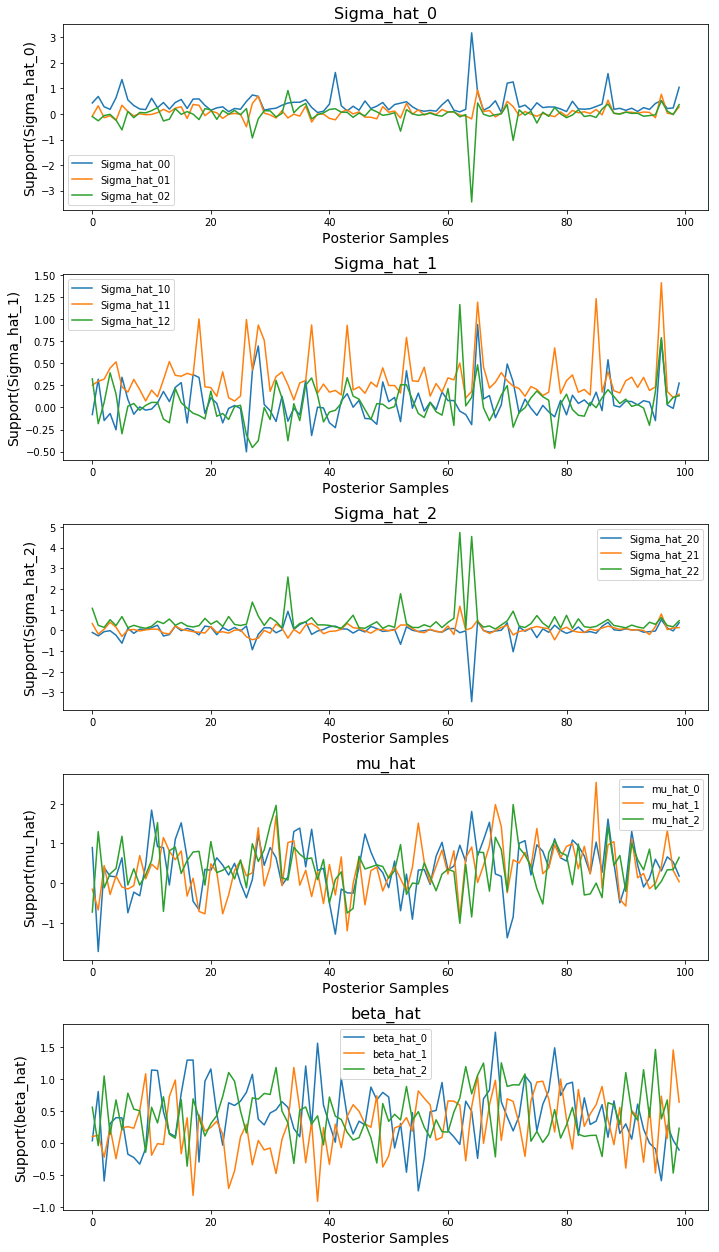

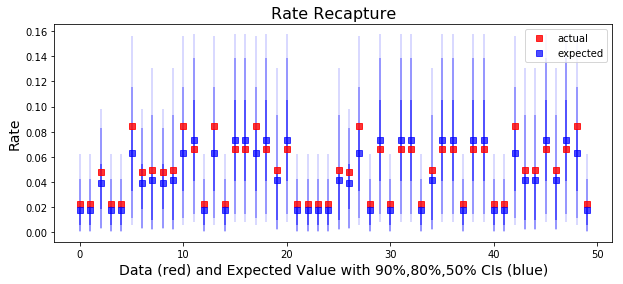

In [42]:
ModelValidator(model).validate(design_matrix, ys, rates)

What happens if we simulate data with a non-identity covariance for the effects?

In [144]:
num_predictors = 3
effect_cov = stats.invwishart.rvs(
    df=num_predictors + 2,
    scale=np.arange(1, num_predictors + 1, dtype=np.float) * 0.3,
    random_state=np.random.RandomState(2314))
print(effect_cov)
true_effects, rates, design_matrix, ys = simulate_gaussian_data(
    num_arms=10, num_predictors=num_predictors, num_time_steps=100,
    prior_means=np.ones(num_predictors, dtype=np.float) * -0.5,
    prior_cov=effect_cov,
    context_prior_means=np.ones(num_predictors, dtype=np.float),
    seed=1)

[[ 0.06217898 -0.00959834  0.05897102]
 [-0.00959834  0.1231746  -0.01623123]
 [ 0.05897102 -0.01623123  0.22053888]]
True effects: [-0.1454 -0.826   0.1826]
Context matrix size: (10, 3)
Samples per arm: [10 11  9  4 10 10  9 17 11  9]
True rates: [0.1458185  0.41205845 0.08816057 0.44577899 0.34372435 0.18584295
 0.16684177 0.40674288 0.41710197 0.38083933]
Design matrix size: (100, 3)
32 successes out of 100 samples


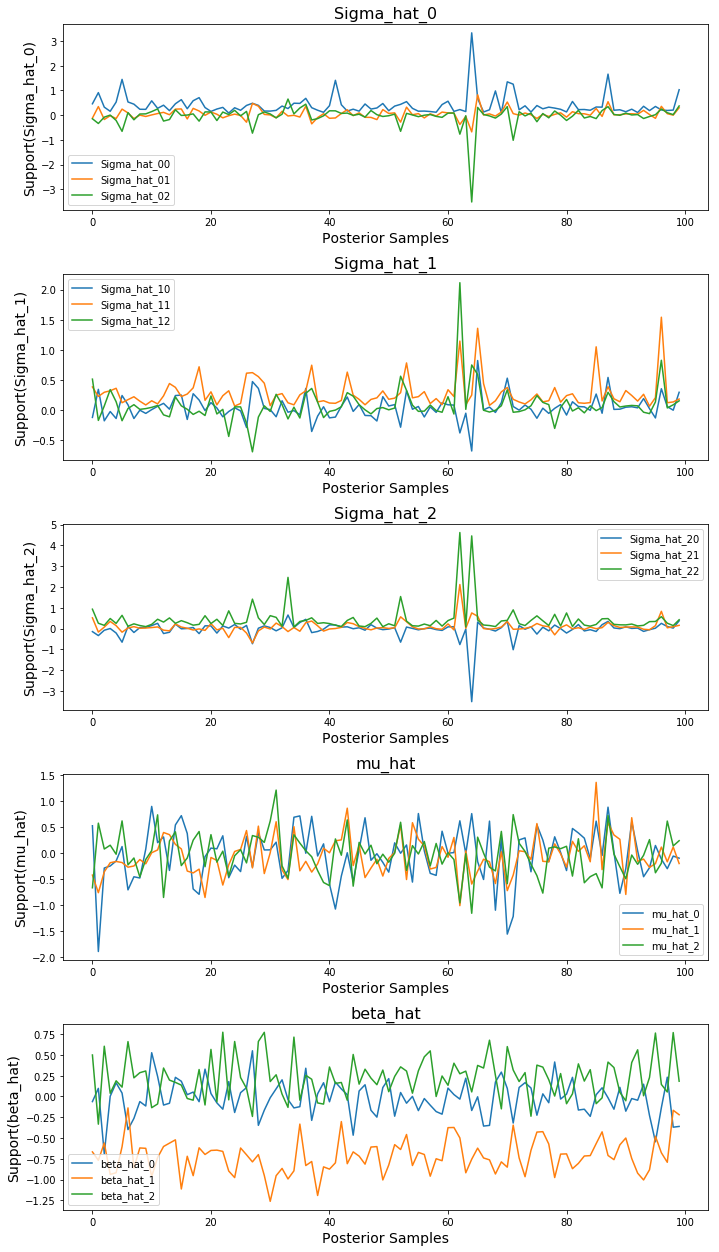

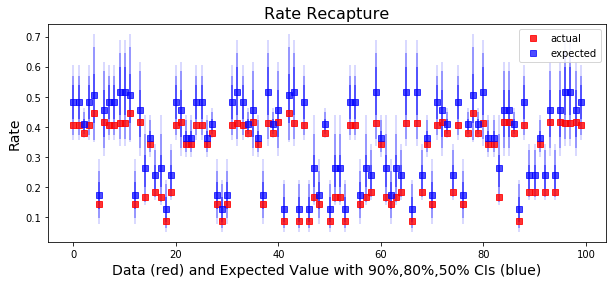

In [145]:
num_predictors = design_matrix.shape[1]
model = LogisticRegressionNIW(
    eta0=1, num_samples=150, num_burnin=50)
model.fit(design_matrix, ys)
ModelValidator(model).validate(design_matrix, ys, rates)

How does the PG-TS LR stack up to that?

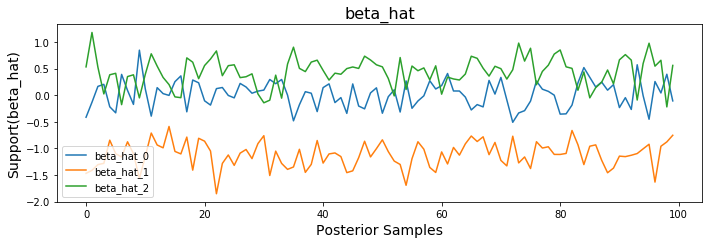

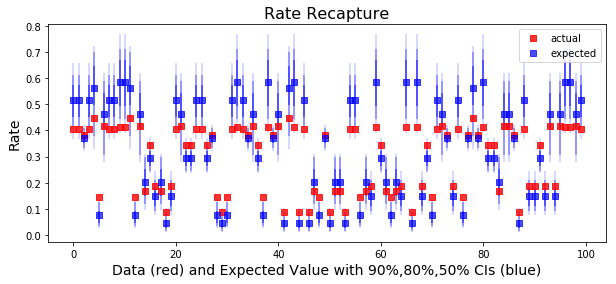

In [146]:
num_predictors = design_matrix.shape[1]
model = LogisticRegression(
    m0=np.zeros(num_predictors),
    P0=np.identity(num_predictors, dtype=np.float),
    num_samples=100)
model.fit(design_matrix, ys)
ModelValidator(model).validate(design_matrix, ys, rates)

Let's compare to the PG-TS on the same simulation we used to replicate experiment 1.

[2019-03-03 18:08:45,088][INFO]: True effects: [ 0.3705  0.5342  2.9009 -0.4323  0.275   1.428   0.4041 -0.0516 -2.7478
 -0.181 ]
[2019-03-03 18:08:45,089][INFO]: Context matrix size: (100, 10)


GaussianSimulationEnvironment, num_predictors=10, num_arms=100, max_arm_rate=0.99213, mean_arm_rate=0.07991

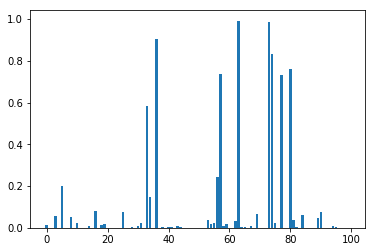

In [210]:
factory1 = GaussianSimulationFactory(seed=2135)
environment = factory1()
plt.bar(np.arange(environment.num_arms), environment.arm_rates)
environment

In [222]:
def contains_all(dirpath, *filenames):
    listing = os.listdir(dirpath)
    return all(fname in listing for fname in filenames)

In [223]:
niw_hyperparams = dict(
    mu0=np.zeros(factory1.num_predictors, dtype=np.float),
    nu0=factory1.num_predictors + 2,
    Lambda0=np.identity(factory1.num_predictors, dtype=np.float))

In [ ]:
if not contains_all('data', 'niw_50_rewards.pkl', 'niw_50_optimal_rewards.pkl'):
    factory1.reset()
    model = LogisticRegressionNIW(num_samples=50, **niw_hyperparams)
    experiment = Experiment(factory1, model, logging_frequency=500)
    niw_50_rewards, niw_50_optimal_rewards = experiment.run(num_replications=100)
    
    # Save NIW results.
    with open('data/niw_50_rewards.pkl', 'wb') as f:
        pickle.dump(niw_50_rewards, f)

    with open('data/niw_50_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(niw_50_optimal_rewards, f)
else:
    # Load results from NIW experiments.
    with open('data/niw_50_rewards.pkl', 'rb') as f:
        niw_50_rewards = pickle.load(f)

    with open('data/niw_50_optimal_rewards.pkl', 'rb') as f:
        niw_50_optimal_rewards = pickle.load(f)

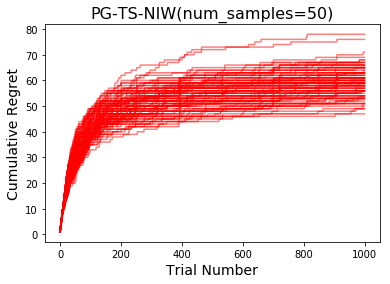

In [227]:
plot_cum_regret(niw_50_rewards, niw_50_optimal_rewards,
                title='PG-TS-NIW(num_samples=50)');

In [ ]:
if not contains_all('data', 'niw_100_rewards.pkl', 'niw_100_optimal_rewards.pkl'):
    factory1.reset()
    model = LogisticRegressionNIW(num_samples=100, **niw_hyperparams)
    experiment = Experiment(factory, model, logging_frequency=500)
    niw_100_rewards, niw_100_optimal_rewards = experiment.run(num_replications=100)
    
    # Save NIW results.
    with open('data/niw_100_rewards.pkl', 'wb') as f:
        pickle.dump(niw_100_rewards, f)

    with open('data/niw_100_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(niw_100_optimal_rewards, f)
else:
    # Load results from NIW experiments.
    with open('data/niw_100_rewards.pkl', 'rb') as f:
        niw_100_rewards = pickle.load(f)

    with open('data/niw_100_optimal_rewards.pkl', 'rb') as f:
        niw_100_optimal_rewards = pickle.load(f)

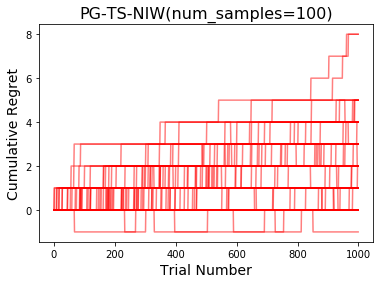

In [229]:
plot_cum_regret(niw_100_rewards, niw_100_optimal_rewards,
                title='PG-TS-NIW(num_samples=100)');

Now let's compare on a more interesting example that actually involves covariance.

[2019-03-03 19:59:21,125][INFO]: True effects: [-1.0736 -0.8071 -0.3373 -0.723   1.0119  0.4429  1.0274 -1.3319  1.6775
 -1.9764]
[2019-03-03 19:59:21,126][INFO]: Context matrix size: (100, 10)


GaussianSimulationEnvironment, num_predictors=10, num_arms=100, max_arm_rate=0.42303, mean_arm_rate=0.13253

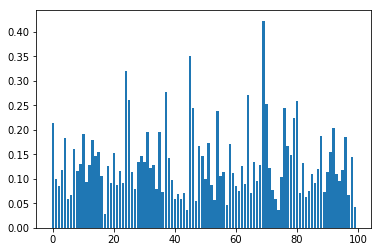

In [230]:
num_predictors = 10
num_arms = 100
effect_cov = stats.invwishart.rvs(
    df=num_predictors + 2,
    scale=np.arange(1, num_predictors + 1, dtype=np.float) * 0.1,
    random_state=np.random.RandomState(2314))
factory2 = GaussianSimulationFactory(
    num_arms=100, num_predictors=num_predictors,
    prior_effect_means=np.ones(num_predictors, dtype=np.float) * -0.5,
    prior_effect_cov=effect_cov,
    prior_context_means=np.ones(num_predictors, dtype=np.float) * 1,
    prior_context_cov=effect_cov * 0.001,
    seed=1234)
environment = factory2()
plt.bar(np.arange(environment.num_arms), environment.arm_rates)
environment

In [ ]:
if not contains_all('data', 'niw_hard_sim_rewards.pkl', 'niw_hard_sim_optimal_rewards.pkl'):
    factory2.reset()
    model = LogisticRegressionNIW(num_samples=100, **niw_hyperparams)
    experiment = Experiment(factory2, model, logging_frequency=500)
    niw_hard_sim_rewards, niw_hard_sim_optimal_rewards = experiment.run(num_replications=100)
    
    # Save NIW results.
    with open('data/niw_hard_sim_rewards.pkl', 'wb') as f:
        pickle.dump(niw_hard_sim_rewards, f)

    with open('data/niw_hard_sim_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(niw_hard_sim_optimal_rewards, f)
else:
    # Load results from NIW experiments.
    with open('data/niw_hard_sim_rewards.pkl', 'rb') as f:
        niw_hard_sim_rewards = pickle.load(f)

    with open('data/niw_hard_sim_optimal_rewards.pkl', 'rb') as f:
        niw_hard_sim_optimal_rewards = pickle.load(f)

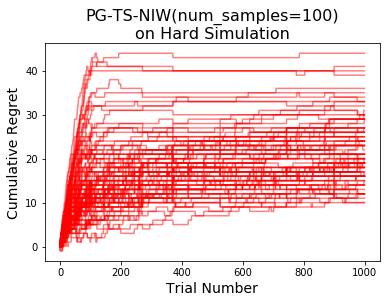

In [237]:
plot_cum_regret(niw_hard_sim_rewards, niw_hard_sim_optimal_rewards,
                title='PG-TS-NIW(num_samples=100)\non Hard Simulation')

In [ ]:
if not contains_all('data', 'pg_ts_hard_sim_rewards.pkl',
                    'pg_ts_hard_sim_optimal_rewards.pkl'):
    factory2.reset()
    model = LogisticRegression(
        m0=np.zeros(factory.num_predictors),
        P0=np.identity(factory.num_predictors, dtype=np.float),
        num_samples=100)
    experiment = Experiment(factory2, model, logging_frequency=500)
    pg_ts_hard_sim_rewards, pg_ts_hard_sim_optimal_rewards = \
        experiment.run(num_replications=100)

    # Save results from PG-TS experiments.
    with open('data/pg_ts_hard_sim_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_hard_sim_rewards, f)

    with open('data/pg_ts_hard_sim_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_hard_sim_optimal_rewards, f)
else:
    # Load results from PG-TS experiments.
    with open('data/pg_ts_hard_sim_rewards.pkl', 'rb') as f:
        pg_ts_hard_sim_rewards = pickle.load(f)

    with open('data/pg_ts_hard_sim_optimal_rewards.pkl', 'rb') as f:
        pg_ts_hard_sim_optimal_rewards = pickle.load(f)

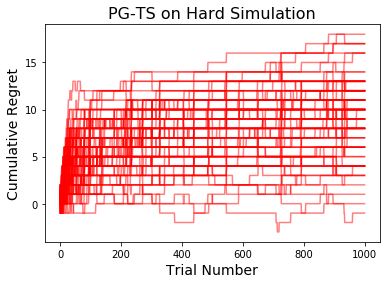

In [234]:
plot_cum_regret(pg_ts_hard_sim_rewards, pg_ts_hard_sim_optimal_rewards,
                title='PG-TS on Hard Simulation')

TODO: add an option to `GaussianSimulationEnvironment` to "level out" the arms with rates above a certain threshold by replacing their context vectors with either the overall mean or by using some kind of 5-NN or something like that.